In [1]:
import torch
import matplotlib.pyplot as plt
import torch
import torch
import torch
import re
import torch
from pathlib import Path
from dftorch.BondIntegral import bond_integral_vectorized
# ============================================================
# Parser for your format:
#   <ElA> <ElB> <channel>
#   <Npoints>
#   R   S(R)   H(R)   (Overlap first, Hamiltonian second)
# ============================================================

_HEADER_RE = re.compile(r'^\s*([A-Za-z][a-z]?)\s+([A-Za-z][a-z]?)\s+([spdf]{2}[spdf])\s*$')

def read_skf_triplet_blocks(skf_path: str):
    """
    Returns list of blocks: {'elemA','elemB','channel','R','S','H','npoints'}
    """
    lines = Path(skf_path).read_text(errors='ignore').splitlines()
    i, n = 0, len(lines)
    blocks = []

    def _next(idx):
        while idx < n and (not lines[idx].strip() or lines[idx].strip().startswith(('#',';','!','%'))):
            idx += 1
        return idx

    while i < n:
        i = _next(i)
        if i >= n:
            break
        m = _HEADER_RE.match(lines[i])
        if not m:
            i += 1
            continue

        Ael, Bel, ch = m.group(1), m.group(2), m.group(3)
        i += 1
        i = _next(i)
        if i >= n:
            break
        try:
            npoints = int(lines[i].split()[0])
        except Exception as e:
            raise ValueError(f"Expected Npoints after header '{Ael} {Bel} {ch}' at line {i+1}") from e
        i += 1

        R_lst, S_lst, H_lst = [], [], []
        read = 0
        while i < n and read < npoints:
            ln = lines[i].strip()
            i += 1
            if not ln or ln.startswith(('#',';','!','%')):
                continue
            parts = ln.split()
            if len(parts) < 3:
                continue
            r = float(parts[0].replace('D','E').replace('d','e'))
            s = float(parts[1].replace('D','E').replace('d','e'))  # Overlap
            h = float(parts[2].replace('D','E').replace('d','e'))  # Hamiltonian
            R_lst.append(r); S_lst.append(s); H_lst.append(h); read += 1

        if read != npoints:
            raise ValueError(f"Block '{Ael} {Bel} {ch}': expected {npoints} numeric rows, got {read}")

        R = torch.tensor(R_lst, dtype=torch.double)
        order = torch.argsort(R)
        blocks.append({
            'elemA': Ael, 'elemB': Bel, 'channel': ch, 'npoints': npoints,
            'R': R[order],
            'S': torch.tensor(S_lst, dtype=torch.double)[order],
            'H': torch.tensor(H_lst, dtype=torch.double)[order],
        })

    if not blocks:
        raise ValueError(f"No blocks parsed in {skf_path}")
    return blocks

# ============================================================
# Tail from head parameters (NO in-place). Pure functional.
# Inputs: f0, c1..c4, f5, R1, R2  -> returns a..f (6,)
# NOTE: tail is for the CORE X(R) (no f0 scaling), consistent with your evaluator.
# ============================================================

def tail_from_head_noinplace(f0, c1, c2, c3, c4, f5, R1, R2):
    RMOD  = R1 - f5
    POLY  = RMOD * (c1 + RMOD * (c2 + RMOD * (c3 + c4 * RMOD)))
    X1    = torch.exp(POLY)                            # value of X at R1 (no f0)
    DP    = c1 + 2*c2*RMOD + 3*c3*RMOD**2 + 4*c4*RMOD**3
    DDP   = 2*c2 + 6*c3*RMOD + 12*c4*RMOD**2

    a = X1
    b = DP * X1
    c = (DP*DP + DDP) * X1 / 2

    DELTA  = R2 - R1
    DELTA2 = DELTA * DELTA
    DELTA3 = DELTA2 * DELTA
    DELTA4 = DELTA3 * DELTA

    # smooth-to-zero boundary at R2 (value/slope/curvature = 0)
    d = -(3*c*DELTA2 + 6*b*DELTA + 10*a) / DELTA3
    e =  (3*c*DELTA2 + 8*b*DELTA + 15*a) / DELTA4
    f = -(6*e*DELTA2 + 3*d*DELTA + c) / (10*DELTA3)

    return torch.stack([a, b, c, d, e, f])

# ============================================================
# Piecewise evaluator (NO in-place). Uses full f (14,) vector.
# X = exp(quartic) for R<=R1; quintic tail for R1<R<R2; 0 beyond.
# Final Y = f0 * X.  (Tail is built for the core X, not scaled.)
# ============================================================

def eval_bond_integral_where(R: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    f0, c1, c2, c3, c4, f5, R1, R2 = f[0], f[1], f[2], f[3], f[4], f[5], f[6], f[7]
    a, b, c, d, e, g = f[8], f[9], f[10], f[11], f[12], f[13]

    # Region masks (do not depend on trainable f except via R1/R2, which we keep fixed)
    reg1 = (R > 1e-12) & (R <= R1)
    reg2 = (R > R1) & (R < R2)

    # Region 1 core X
    RMOD = R - f5
    poly = RMOD * (c1 + RMOD * (c2 + RMOD * (c3 + c4 * RMOD)))
    X1   = torch.exp(poly)

    # Region 2 core X via quintic in t = R - R1
    t  = R - R1
    P  = a + t*(b + t*(c + t*(d + t*(e + t*g))))

    X = torch.where(reg1, X1, torch.where(reg2, P, torch.zeros_like(R)))
    return f0 * X

# ============================================================
# Initialization (no grad): pick R1/R2, do small linear LS on log|V|
# ============================================================

@torch.no_grad()
def init_head_params(R: torch.Tensor, V: torch.Tensor,
                     R1: float | None, R2: float | None,
                     frac_thresh=0.05, min_pts_reg1=8):
    R = R.double(); V = V.double()
    N = R.numel()
    if R2 is None:
        R2 = float(R[-1].item())
    if R1 is None:
        absV = V.abs(); vmax = absV.max().item()
        idx  = torch.nonzero(absV <= frac_thresh * vmax, as_tuple=False)
        R1   = float(R[idx[0]].item()) if idx.numel() > 0 else float(R[int(0.7*(N-1))].item())
        R1   = min(R1, R2 - 1e-6)

    m1 = R <= R1 + 1e-12
    Rr, Vr = R[m1], V[m1]
    if Rr.numel() < min_pts_reg1:
        need  = min_pts_reg1 - Rr.numel()
        last  = m1.nonzero()[-1].item() if m1.any() else -1
        newix = min(last + need, N-1)
        R1    = float(R[newix].item())
        m1    = R <= R1 + 1e-12
        Rr, Vr = R[m1], V[m1]

    # enforce single-sign region for log-fit
    flips = torch.nonzero(Vr[:-1]*Vr[1:] <= 0, as_tuple=False)
    if flips.numel() > 0:
        cut = int(flips[0].item()) + 1
        R1  = float(Rr[cut-1].item())
        Rr, Vr = Rr[:cut], Vr[:cut]

    sgn = torch.sign(Vr.median())
    if sgn == 0:
        sgn = torch.sign(Vr[torch.argmax(Vr.abs())])
        if sgn == 0:
            sgn = torch.tensor(1.0, dtype=R.dtype)

    # f5 near the largest |V| in region-1
    f5 = float(Rr[torch.argmax(Vr.abs())].item())
    Δ  = Rr - f5
    y  = torch.log(Vr.abs().clamp_min(1e-300))
    X  = torch.stack([torch.ones_like(Δ), Δ, Δ**2, Δ**3, Δ**4], dim=1)
    beta = torch.linalg.lstsq(X, y).solution
    a0, c1, c2, c3, c4 = [float(b.item()) for b in beta]
    f0 = float(torch.exp(torch.tensor(a0)).item()) * float(sgn.item())
    return f0, c1, c2, c3, c4, float(f5), float(R1), float(R2)

# ============================================================
# Adam fitter with tail participating in loss (NO in-place)
# ============================================================

def fit_f_adam_full(R: torch.Tensor, V: torch.Tensor,
                    R1: float | None = None, R2: float | None = None,
                    steps: int = 2000, lr: float = 1e-3, l2: float = 1e-10,
                    use_scheduler: bool = True, step_size: int = 500, gamma: float = 0.5):
    device = R.device
    dtype  = R.dtype
    R = R.to(torch.double)
    V = V.to(torch.double)

    # init head
    f0_i, c1_i, c2_i, c3_i, c4_i, f5_i, R1_i, R2_i = init_head_params(R, V, R1, R2)

    # trainable head params
    f0 = torch.nn.Parameter(torch.tensor(f0_i, dtype=torch.double, device=device))
    c1 = torch.nn.Parameter(torch.tensor(c1_i, dtype=torch.double, device=device))
    c2 = torch.nn.Parameter(torch.tensor(c2_i, dtype=torch.double, device=device))
    c3 = torch.nn.Parameter(torch.tensor(c3_i, dtype=torch.double, device=device))
    c4 = torch.nn.Parameter(torch.tensor(c4_i, dtype=torch.double, device=device))

    # bound f5 in [Rmin, R1] with sigmoid
    Rmin  = float(R.min().item())
    R1fix = torch.tensor(R1_i, dtype=torch.double, device=device)  # fixed
    R2fix = torch.tensor(R2_i, dtype=torch.double, device=device)  # fixed
    span  = max(R1_i - Rmin, 1e-6)
    theta = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.double, device=device))  # f5 = Rmin + span*sigmoid(theta)

    opt = torch.optim.Adam([f0, c1, c2, c3, c4, theta], lr=lr)
    sch = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) if use_scheduler else None

    losses = []
    for t in range(steps):
        opt.zero_grad()
        f5 = torch.tensor(Rmin, dtype=torch.double, device=device) + span * torch.sigmoid(theta)

        # build tail (no in-place), then the full f vector (no in-place)
        tail = tail_from_head_noinplace(f0, c1, c2, c3, c4, f5, R1fix, R2fix)  # (6,)
        fvec = torch.stack([f0, c1, c2, c3, c4, f5, R1fix, R2fix, *tail])      # (14,)

        Yhat = eval_bond_integral_where(R, fvec)
        loss = torch.mean((Yhat - V) ** 2) + l2 * (f0*f0 + c1*c1 + c2*c2 + c3*c3 + c4*c4)
        if t%100 == 0:
            print(t, loss.item())

        loss.backward()
        opt.step()
        if sch is not None:
            sch.step()

        losses.append(float(loss.item()))

    # final f (detach, cast to original dtype)
    with torch.no_grad():
        f5 = torch.tensor(Rmin, dtype=torch.double, device=device) + span * torch.sigmoid(theta)
        tail = tail_from_head_noinplace(f0.detach(), c1.detach(), c2.detach(), c3.detach(), c4.detach(), f5.detach(), R1fix, R2fix)
        f_final = torch.stack([
            f0.detach(), c1.detach(), c2.detach(), c3.detach(), c4.detach(),
            f5.detach(), R1fix, R2fix, *tail
        ]).to(dtype)
    return f_final, losses

# ============================================================
# End-to-end convenience: pick block + column (H or S), fit
# ============================================================

def fit_from_triplet_skf_with_tail(skf_path: str, channel: str, which: str='H',
                                   elem_pair: tuple[str,str] | None=None,
                                   **train_kwargs):
    blocks = read_skf_triplet_blocks(skf_path)
    cand = [b for b in blocks
            if b['channel'].lower() == channel.lower()
            and (elem_pair is None or (b['elemA'], b['elemB']) == elem_pair)]
    if not cand:
        avail = [(b['elemA'], b['elemB'], b['channel']) for b in blocks]
        raise ValueError(f"No block found for channel='{channel}' and elem_pair={elem_pair}. Available: {avail}")

    blk = cand[0]
    R = blk['R']
    V = blk['H'] if which.upper() == 'H' else blk['S']

    f, losses = fit_f_adam_full(R, V, **train_kwargs)
    meta = {'elemA': blk['elemA'], 'elemB': blk['elemB'], 'channel': blk['channel'],
            'which': which.upper(), 'R': R, 'V': V, 'losses': losses}
    return f, meta

# ============================================================
# Example (uncomment to run):
# f_cc_pps_H, meta = fit_from_triplet_skf_with_tail(
#     "sk/bondints.table",
#     channel="pps", which="H", elem_pair=("C","C"),
#     steps=1200, lr=3e-2, use_scheduler=True, step_size=300, gamma=0.5
# )
# dR = meta['R']
# Y  = eval_bond_integral_where(dR, f_cc_pps_H)
# ============================================================

In [ ]:
def fit_f_adam_full(R: torch.Tensor, V: torch.Tensor,
                    R1: float | None = None, R2: float | None = None,
                    steps: int = 2000, lr: float = 1e-3, l2: float = 1e-10,
                    use_scheduler: bool = True, step_size: int = 500, gamma: float = 0.5):
    device = R.device
    dtype  = R.dtype
    R = R.to(torch.double)
    V = V.to(torch.double)

    # init head
    #f0_i, c1_i, c2_i, c3_i, c4_i, f5_i, R1_i, R2_i = init_head_params(R, V, R1, R2)
    f0_i, c1_i, c2_i, c3_i, c4_i, f5_i, R1_i, R2_i = torch.tensor(-4.526526), torch.tensor(-2.487174), \
                                                     torch.tensor(-0.201464), torch.tensor(0.0), torch.tensor(0.0), torch.tensor(1.2),\
                                                     torch.tensor(3.5), torch.tensor(4.0),

    # trainable head params
    f0 = torch.nn.Parameter(torch.tensor(f0_i, dtype=torch.double, device=device))
    c1 = torch.nn.Parameter(torch.tensor(c1_i, dtype=torch.double, device=device))
    c2 = torch.nn.Parameter(torch.tensor(c2_i, dtype=torch.double, device=device))
    c3 = torch.nn.Parameter(torch.tensor(c3_i, dtype=torch.double, device=device))
    c4 = torch.nn.Parameter(torch.tensor(c4_i, dtype=torch.double, device=device))
    f5 = torch.nn.Parameter(torch.tensor(f5_i, dtype=torch.double, device=device))

    # bound f5 in [Rmin, R1] with sigmoid
    Rmin  = float(R.min().item())
    R1fix = torch.tensor(R1_i, dtype=torch.double, device=device)  # fixed
    R2fix = torch.tensor(R2_i, dtype=torch.double, device=device)  # fixed
    span  = max(R1_i - Rmin, 1e-6)
    theta = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.double, device=device))  # f5 = Rmin + span*sigmoid(theta)

    opt = torch.optim.Adam([f0, c1, c2, c3, c4, theta], lr=lr)
    sch = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) if use_scheduler else None

    losses = []
    for t in range(steps):
        opt.zero_grad()
        f5 = torch.tensor(Rmin, dtype=torch.double, device=device) + span * torch.sigmoid(theta)

        # build tail (no in-place), then the full f vector (no in-place)
        tail = tail_from_head_noinplace(f0, c1, c2, c3, c4, f5, R1fix, R2fix)  # (6,)
        fvec = torch.stack([f0, c1, c2, c3, c4, f5, R1fix, R2fix, *tail])      # (14,)

        Yhat = eval_bond_integral_where(R, fvec)
        loss = torch.mean((Yhat - V) ** 2) + l2 * (f0*f0 + c1*c1 + c2*c2 + c3*c3 + c4*c4)
        if t%100 == 0:
            print(t, loss.item())

        loss.backward()
        opt.step()
        if sch is not None:
            sch.step()

        losses.append(float(loss.item()))

    # final f (detach, cast to original dtype)
    with torch.no_grad():
        f5 = torch.tensor(Rmin, dtype=torch.double, device=device) + span * torch.sigmoid(theta)
        tail = tail_from_head_noinplace(f0.detach(), c1.detach(), c2.detach(), c3.detach(), c4.detach(), f5.detach(), R1fix, R2fix)
        f_final = torch.stack([
            f0.detach(), c1.detach(), c2.detach(), c3.detach(), c4.detach(),
            f5.detach(), R1fix, R2fix, *tail
        ]).to(dtype)
    return f_final, losses


In [5]:
torch.tensor(-4.526526)

tensor(-4.5265)

In [4]:
# Fit C–C ppσ (your file uses 'pps'/'ppp') for the **Hamiltonian** table
torch.autograd.set_detect_anomaly(True)

f_cc_ppsigma, meta = fit_from_triplet_skf_with_tail(
    "sk/bondints.table",
    channel="sss",          # 'pps' ~ pp sigma; 'ppp' ~ pp pi; 'sps' ~ sp sigma
    which="H",              # 'H' for Hamiltonian, 'S' for Overlap
    elem_pair=("C","C"),    # optional; omit to take the first matching block
    # Optional fitter controls:
    #R1=4.0, R2=5.0, #frac_thresh=0.05, adam_steps=1000, lr=3e-2
)

# Evaluate at distances:
dR = meta['R']#torch.linspace(0.2, 5.5, 500, dtype=torch.double)
Y = bond_integral_vectorized(dR, f_cc_ppsigma.repeat(len(dR),1))

0 8432058.030790797
100 1841971.9961102735
200 914178.0727847187
300 577293.597673709
400 408983.41640689626
500 310072.56129892287
600 274266.6665077382
700 243593.29189545225
800 217338.87649441135
900 194831.80762520182
1000 175466.8831880724
1100 166679.08545359434
1200 158229.50263693937
1300 150138.76299672184
1400 142420.13972327765
1500 135077.7782736386
1600 131501.36923967808
1700 127918.00256564477
1800 124338.30205501962
1900 120772.74981743064


In [3]:
f_cc_ppsigma

tensor([-5.3351e+01, -1.0107e+01,  1.7257e+01, -5.6395e+00, -8.3978e+00,
         3.1988e-01,  7.6202e-01,  5.4929e+00,  1.4904e-01, -1.5764e-01,
         7.2411e-02, -1.7732e-02,  2.2580e-03, -1.1709e-04],
       dtype=torch.float64)

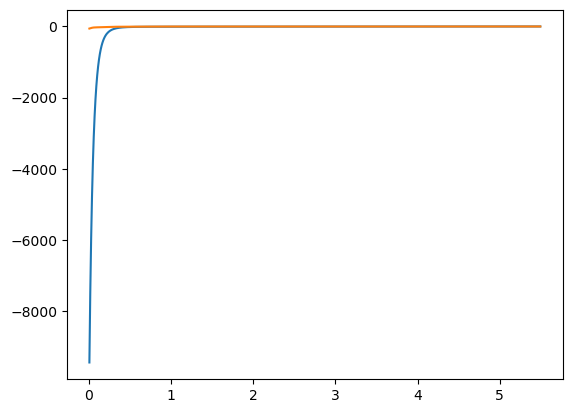

In [24]:
plt.plot(dR, Y.cpu())
plt.plot(meta['R'], meta['V'])

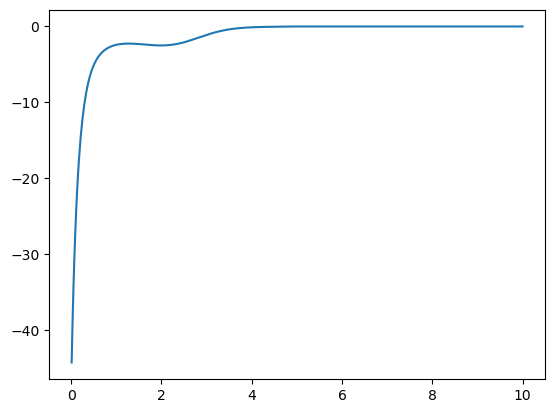

In [262]:
import numpy as np
x = np.linspace(0.01,10,500)
R = torch.tensor(x, dtype=torch.double)
out = bond_integral_vectorized(R,f_cc_ppsigma.repeat(500,1))
plt.plot(x, out.cpu())

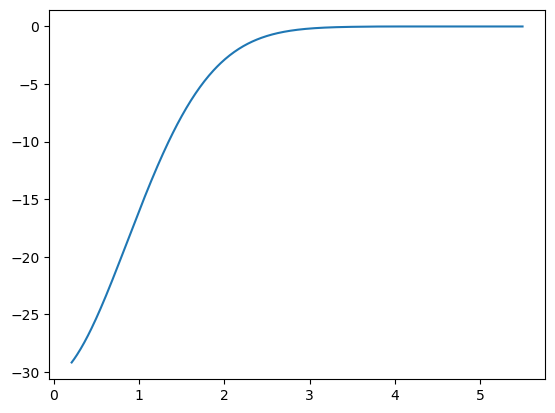

In [110]:
from dftorch.BondIntegral import LoadBondIntegralParameters, bond_integral_vectorized
fss = LoadBondIntegralParameters(torch.tensor([0]), torch.tensor([1]), torch.tensor([6,6]), '../src/dftorch/params/fss_sigma.csv')
out = bond_integral_vectorized(torch.tensor(x, dtype=torch.float32),fss.repeat(500,1))
plt.plot(x, out.cpu())

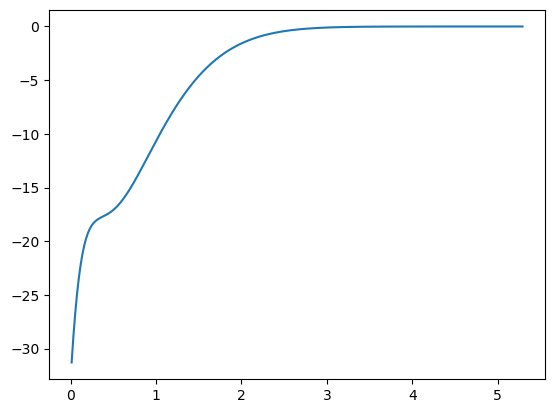

In [51]:
plt.plot(x, C_C_ss*27.2114, label='data')